# EuroSAT - Baseline - Macro/Micro Cambio Climático

In [1]:
!pip install pytorch-lightning
!pip install wandb

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms
import torchvision
import torch.nn as nn
import torchmetrics
from torch.utils.data import DataLoader
import torch.nn.functional as F

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from PIL import Image
import os
import json

from pytorch_lightning.loggers import WandbLogger
import wandb

In [3]:
# wandb.login()
# Registro en WanDB para hacer el tracking del entrenamiento

In [4]:
transformToTensor = transforms.Compose([
transforms.Resize((64,)),
transforms.CenterCrop((64, 64)),
transforms.ToTensor()
]
) # No lo haremos a nivel de batch

In [5]:
f = open("/kaggle/input/eurosat-dataset/EuroSAT/label_map.json", "r")
label_to_index = json.load(f) # Etiquetas de uso de terreno

In [6]:
label_to_index # Tenemos 10 clases

{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}

In [7]:
index_to_label = {label_to_index[k]:k for k in label_to_index} # Indexamos cada label
index_to_label

{0: 'AnnualCrop',
 1: 'Forest',
 2: 'HerbaceousVegetation',
 3: 'Highway',
 4: 'Industrial',
 5: 'Pasture',
 6: 'PermanentCrop',
 7: 'Residential',
 8: 'River',
 9: 'SeaLake'}

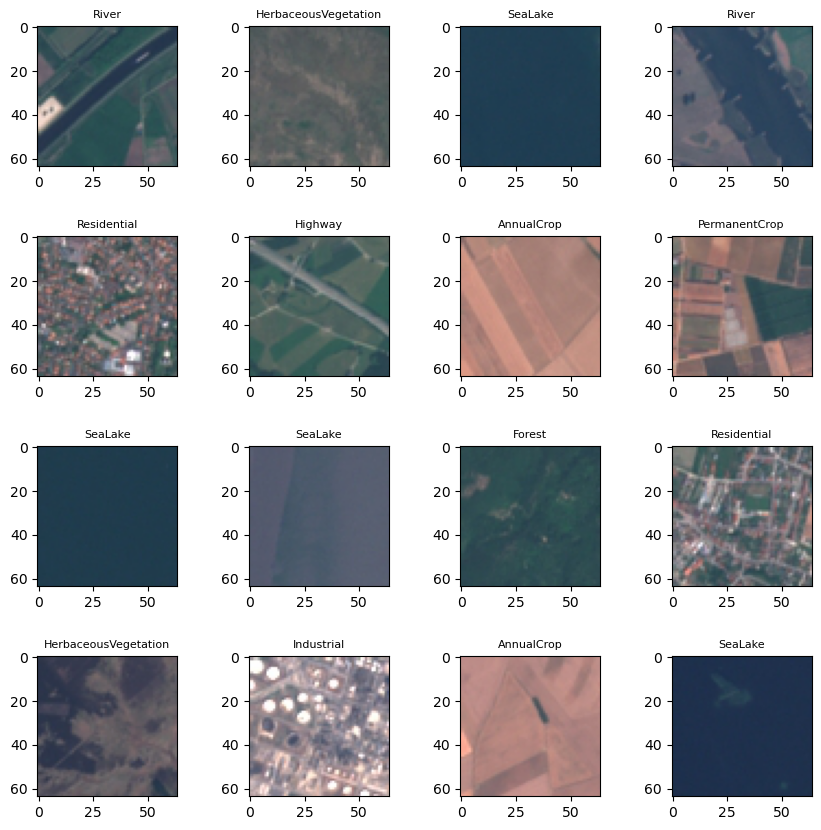

In [8]:
data = pd.read_csv("/kaggle/input/eurosat-dataset/EuroSAT/train.csv")

fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for i in range(4):
    for j in range(4):
        ix = np.random.choice(data.index.tolist())  # Índice aleatorio
        image_path = "/kaggle/input/eurosat-dataset/EuroSAT/" + data.iloc[ix].Filename
        label = data.iloc[ix].ClassName

        # Abrimos la imagen
        img = Image.open(image_path)

        axs[i, j].imshow(img)
        axs[i, j].set_title(label, fontsize=8)

plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.savefig("DataEuroSAT.png")

plt.show()

In [9]:
estadisticas = data['ClassName'].value_counts(normalize = True) * 100
estadisticas = estadisticas.to_latex()

with open('estadisticas.tex', 'w') as f:
    f.write(estadisticas)

In [10]:
img = Image.open("/kaggle/input/eurosat-dataset/EuroSAT/" + "AnnualCrop/AnnualCrop_142.jpg")
img = transformToTensor(img)
img.shape # Dejamos los canales en la primera dimensión

torch.Size([3, 64, 64])

## Data

In [11]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        self.folder_base = "/kaggle/input/eurosat-dataset/EuroSAT/"
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, ix):
        path = self.images[ix] # Path de la imagen
        label = self.labels[ix]
        img = Image.open(self.folder_base + path)
        # Dejamos el canal en la última dimensión
        return transformToTensor(img), torch.tensor(label)

In [12]:
class DataModule(pl.LightningDataModule):
    def __init__(self,
                 batch_size = 64,
                ):
        super().__init__()
        self.batch_size = batch_size
    
    def setup(self, stage=None):
        # Las listas despúes las pasamos al Dataset
        train = pd.read_csv("/kaggle/input/eurosat-dataset/EuroSAT/train.csv")
        train_images = train['Filename'].tolist()
        train_labels = train['Label'].tolist()
        self.train_ds = Dataset(train_images, train_labels)
        
        val = pd.read_csv("/kaggle/input/eurosat-dataset/EuroSAT/validation.csv")
        val_images = val['Filename'].tolist()
        val_labels = val['Label'].tolist()
        self.val_ds = Dataset(val_images, val_labels)

    def train_dataloader(self, shuffle=True):
        return DataLoader(
            self.train_ds, 
            batch_size = self.batch_size, 
            shuffle = True,
            num_workers = 2,
            persistent_workers=True
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.val_ds, 
            batch_size = self.batch_size,
            num_workers = 2,
            persistent_workers=True
        )

In [13]:
dm = DataModule()
dm.setup()

images, labels = next(iter(dm.train_dataloader()))
images.shape, labels.shape, images.dtype, labels.dtype
# Checkeamos dimensiones

(torch.Size([64, 3, 64, 64]), torch.Size([64]), torch.float32, torch.int64)

## Model

In [14]:
class Model(pl.LightningModule):
    def __init__(self, n_classes = 10):
        super().__init__()
        self.n_classes = n_classes
        self.resnet = torchvision.models.resnet18() # Finetuneamos una resnet 18
        # Cargamos pesos
        self.resnet.load_state_dict(torch.load("/kaggle/input/resnet18/resnet18.pth"))
        # https://download.pytorch.org/models/resnet18-f37072fd.pth
        # Cambiamos última capa de la resnet-18
        self.resnet.fc = torch.nn.Linear(self.resnet.fc.in_features, n_classes)
        
    def forward(self, x):
        return self.resnet(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = torchmetrics.functional.accuracy(y_hat, y, task='multiclass', num_classes=self.n_classes)
        logs = {'train_loss':loss, 'train_acc':acc}
        self.log_dict(
            logs,
            on_step=False, on_epoch=True, prog_bar=True, logger=True
        )
        return loss
    
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = torchmetrics.functional.accuracy(y_hat, y, task='multiclass', num_classes=self.n_classes)
        logs = {'val_loss':loss, 'val_acc':acc}
        self.log_dict(
            logs,
            on_step=False, on_epoch=True, prog_bar=True, logger=True
        )
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=3e-4)
        return optimizer

## Training

In [15]:
CONFIG = dict (
    model_name = 'resnet18',
    pretrained = True,
    num_classes = 10,
    lr = 3e-4,
    num_epochs = 100,
    batch_size = 64
)

es = EarlyStopping(monitor='val_acc', mode='max', patience=3)
# Dejamos de entrenar si la accuracy de la validación no mejora después de 3 logs

checkpoint = ModelCheckpoint(
    filename='/kaggle/working/saves/resnet18-{val_acc:.5f}',
    save_top_k = 1, # Guardamos el modelo con mejor accuracy en la validación
    monitor='val_acc',
    mode='max'
)

#wandb_logger = WandbLogger(project='eurosat-baseline', 
                           #config=CONFIG,
                           #group='ResNet18', 
                           #job_type='train'
                          #)

In [16]:
trainer = pl.Trainer(
    accelerator="auto", 
    devices="auto",
    max_epochs=100,
    log_every_n_steps=10, # Cada 10 batches
    callbacks=[es, checkpoint]
    #logger=wandb_logger
    )

In [17]:
model = Model() # Inicializamos la resnet

In [18]:
trainer.fit(model, dm)
# Guardé los logs en WB

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:540: PossibleUserWarning: It is recommended to use `self.log('val_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  category=PossibleUserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:540: PossibleUserWarning: It is recommended to use `self.log('val_acc', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

[W reducer.cpp:1298] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later iterations to have unused parameters. (function operator())
[W reducer.cpp:1298] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later 

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:540: PossibleUserWarning: It is recommended to use `self.log('train_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  category=PossibleUserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:540: PossibleUserWarning: It is recommended to use `self.log('train_acc', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  category=PossibleUserWarning,


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [19]:
# Mejor modelo guardado
#model = torchvision.models.resnet18()
#checkpoint = torch.load('/kaggle/working/saves/resnet18-val_acc=0.96815.ckpt')
#model.load_state_dict(checkpoint)
#model.eval()

In [20]:
model.eval() # Modo evaluación, apagar dropout y batch normalization general

Model(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

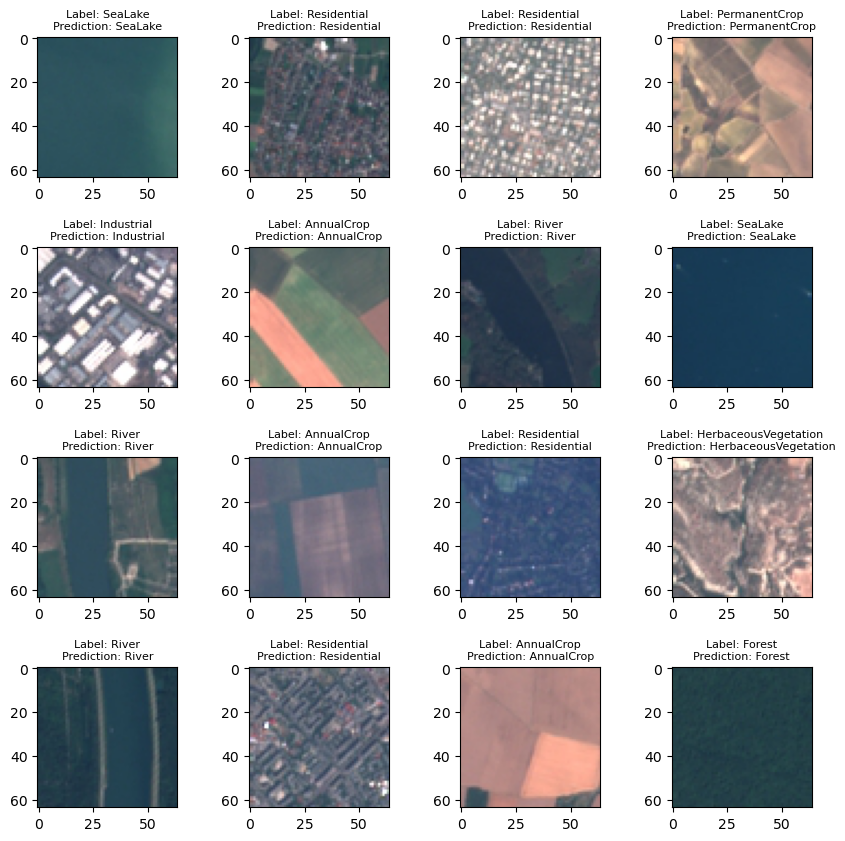

In [21]:
data = pd.read_csv("/kaggle/input/eurosat-dataset/EuroSAT/train.csv")

fig, axs = plt.subplots(4, 4, figsize=(10, 10))

for i in range(4):
    for j in range(4):
        ix = np.random.choice(data.index.tolist())  # Índice aleatorio
        image_path = "/kaggle/input/eurosat-dataset/EuroSAT/" + data.iloc[ix].Filename
        label = data.iloc[ix].ClassName

        img = Image.open(image_path)
        axs[i, j].imshow(img)

        img = transformToTensor(img).unsqueeze(0)  # Agregamos la dimensión del batch
        y_hat = model(img)
        y_probabilities = F.softmax(y_hat, dim=1)
        predicted_class = torch.argmax(y_probabilities, dim=1).item()
        prediction = index_to_label[predicted_class]

        axs[i, j].set_title('Label: ' + label + '\nPrediction: ' + prediction, fontsize=8)

plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.savefig("DataEuroSATValidation.png")

plt.show()